In [26]:
import pandas as pd
import os

# Define file paths and sheet names
base_path = "/Users/muheb/Downloads/Topic 1 3/"
files = {
    "contribution": ("Zusatzbeitrag_je Kasse je Quartal.xlsx", "Sheet1"),
    "morbidity": ("Morbidity_Region.xlsx", "data"),
    "market": ("Marktanteile je Kasse.xlsx", "data")
}

# Load all data into a dictionary of DataFrames
dataframes = {}
for name, (filename, sheetname) in files.items():
    full_path = os.path.join(base_path, filename)
    df = pd.read_excel(full_path, sheet_name=sheetname)
    dataframes[name] = df

# Clean up fund names and year columns for merging
for df in dataframes.values():
    df["Krankenkasse"] = df["Krankenkasse"].str.strip().str.lower()
    df["Jahr"] = df["Jahr"].astype(int)

# Merge all datasets into one DataFrame
merged = pd.merge(
    dataframes["contribution"],
    dataframes["morbidity"][["Krankenkasse", "Jahr", "Risikofaktor"]],
    on=["Krankenkasse", "Jahr"],
    how="left"
)
merged = pd.merge(
    merged,
    dataframes["market"][["Krankenkasse", "Jahr", "Marktanteil Mitglieder", "Marktanteil Versicherte"]],
    on=["Krankenkasse", "Jahr"],
    how="left"
)

# Preview the first rows and check for missing values
print(merged.head(10))
print("\nMissing values per column:\n", merged.isnull().sum())

   Jahr                  Krankenkasse  Quartal  Mitglieder  Versicherte  \
0  2025         aok baden-württemberg        1     3539685      4615478   
1  2025                    aok bayern        1     3627408      4603276   
2  2025        aok bremen/bremerhaven        1      207431       284469   
3  2025                    aok hessen        1     1281555      1730176   
4  2025             aok niedersachsen        1     2324317      3058918   
5  2025                   aok nordost        1     1303932      1619468   
6  2025                  aok nordwest        1     2224273      2960003   
7  2025                      aok plus        1     2767866      3491693   
8  2025  aok rheinland-pfalz/saarland        1      934209      1225364   
9  2025         aok rheinland/hamburg        1     2239511      2999282   

   Zusatzbeitrag Risikofaktor  Marktanteil Mitglieder Marktanteil Versicherte  
0           2.60     0.906069                0.061221                0.062775  
1           2.

Number of unique funds: 131
Years: [2025 2024 2023 2022 2021 2020 2019 2018 2017 2016 2015 2014 2013]
Quarters: [1 2 3 4]


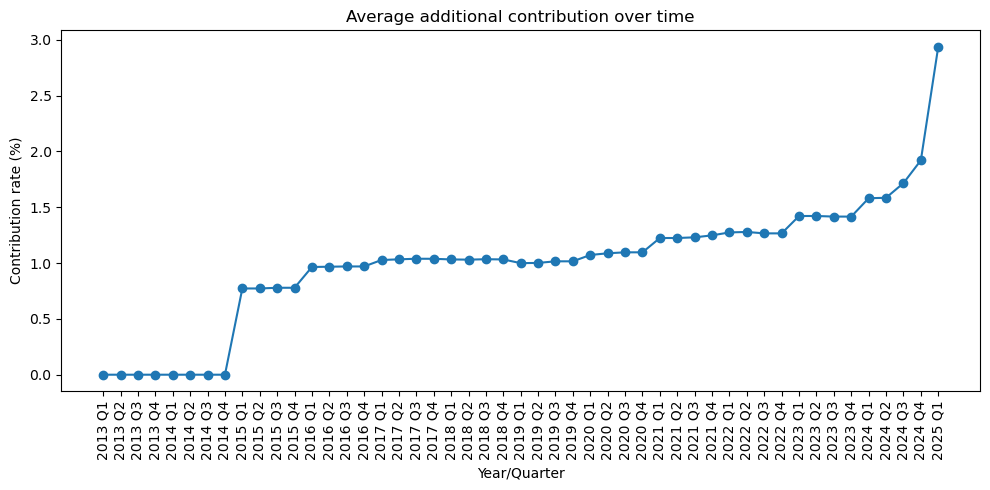

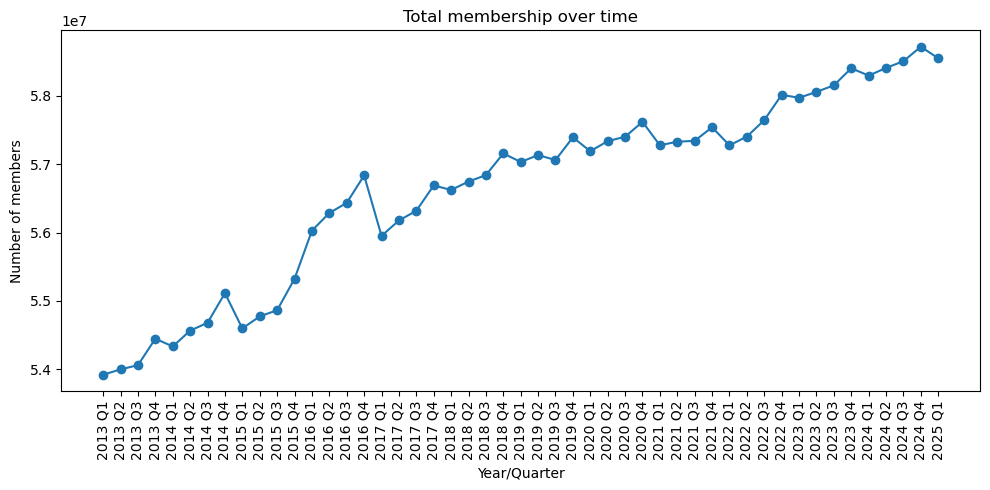

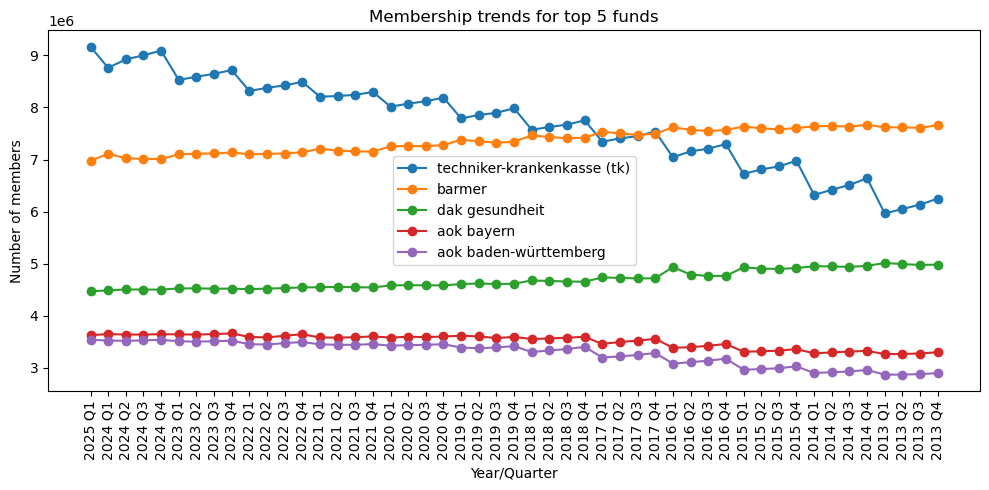

In [29]:
import matplotlib.pyplot as plt

# 1. Basic overview: Number of funds, years, and quarters
print("Number of unique funds:", merged['Krankenkasse'].nunique())
print("Years:", merged['Jahr'].unique())
print("Quarters:", merged['Quartal'].unique())

# 2. Average additional contribution per quarter (all funds)
avg_contribution = merged.groupby(['Jahr', 'Quartal'])['Zusatzbeitrag'].mean().reset_index()
plt.figure(figsize=(10,5))
plt.plot(
    avg_contribution['Jahr'].astype(str) + ' Q' + avg_contribution['Quartal'].astype(str),
    avg_contribution['Zusatzbeitrag'], marker='o'
)
plt.title('Average additional contribution over time')
plt.xlabel('Year/Quarter')
plt.ylabel('Contribution rate (%)')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# 3. Total membership over time (all funds)
total_members = merged.groupby(['Jahr', 'Quartal'])['Mitglieder'].sum().reset_index()
plt.figure(figsize=(10,5))
plt.plot(
    total_members['Jahr'].astype(str) + ' Q' + total_members['Quartal'].astype(str),
    total_members['Mitglieder'], marker='o'
)
plt.title('Total membership over time')
plt.xlabel('Year/Quarter')
plt.ylabel('Number of members')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# 4. Top 5 funds: membership development over time
top_funds = merged.groupby('Krankenkasse')['Mitglieder'].sum().sort_values(ascending=False).head(5).index.tolist()
plt.figure(figsize=(10,5))
for fund in top_funds:
    temp = merged[merged['Krankenkasse'] == fund]
    plt.plot(
        temp['Jahr'].astype(str) + ' Q' + temp['Quartal'].astype(str),
        temp['Mitglieder'], marker='o', label=fund
    )
plt.title('Membership trends for top 5 funds')
plt.xlabel('Year/Quarter')
plt.ylabel('Number of members')
plt.legend()
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

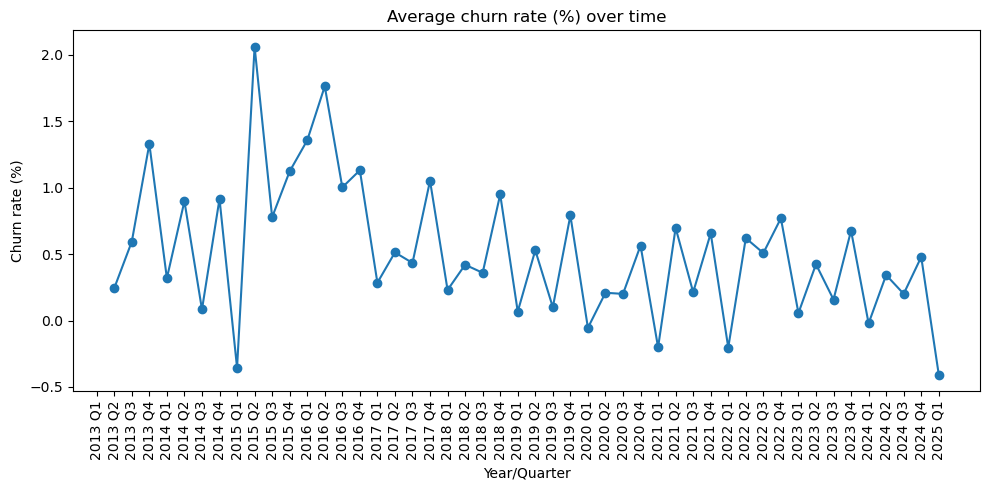

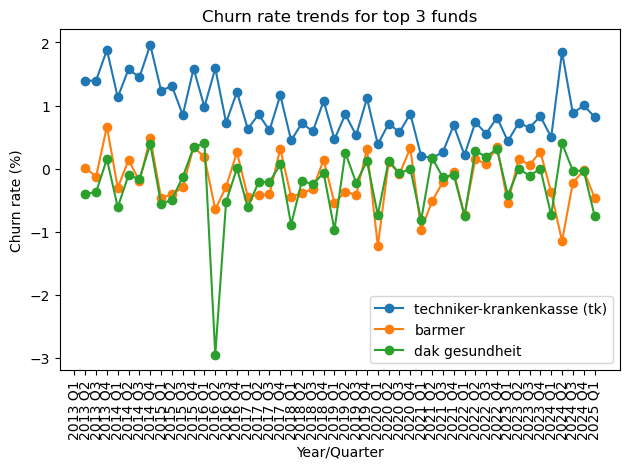

In [30]:
# 1. Sort data and calculate churn per fund and quarter
merged = merged.sort_values(['Krankenkasse', 'Jahr', 'Quartal'])
merged['members_prev'] = merged.groupby('Krankenkasse')['Mitglieder'].shift(1)
merged['churn_abs'] = merged['Mitglieder'] - merged['members_prev']
merged['churn_rel'] = merged['churn_abs'] / merged['members_prev'] * 100

# 2. Average churn rate per quarter (all funds)
avg_churn = merged.groupby(['Jahr', 'Quartal'])['churn_rel'].mean().reset_index()

import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.plot(
    avg_churn['Jahr'].astype(str) + ' Q' + avg_churn['Quartal'].astype(str),
    avg_churn['churn_rel'], marker='o'
)
plt.title('Average churn rate (%) over time')
plt.xlabel('Year/Quarter')
plt.ylabel('Churn rate (%)')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# 3. Churn trends for the top 3 funds
for fund in top_funds[:3]:
    temp = merged[merged['Krankenkasse'] == fund]
    plt.plot(
        temp['Jahr'].astype(str) + ' Q' + temp['Quartal'].astype(str),
        temp['churn_rel'], marker='o', label=fund
    )
plt.title('Churn rate trends for top 3 funds')
plt.xlabel('Year/Quarter')
plt.ylabel('Churn rate (%)')
plt.legend()
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

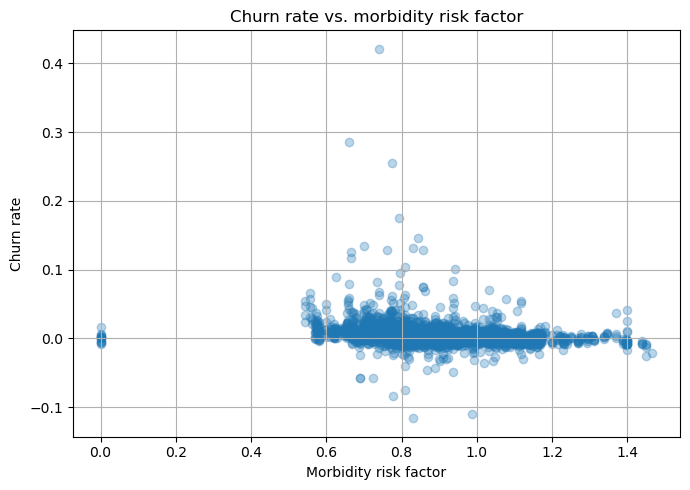

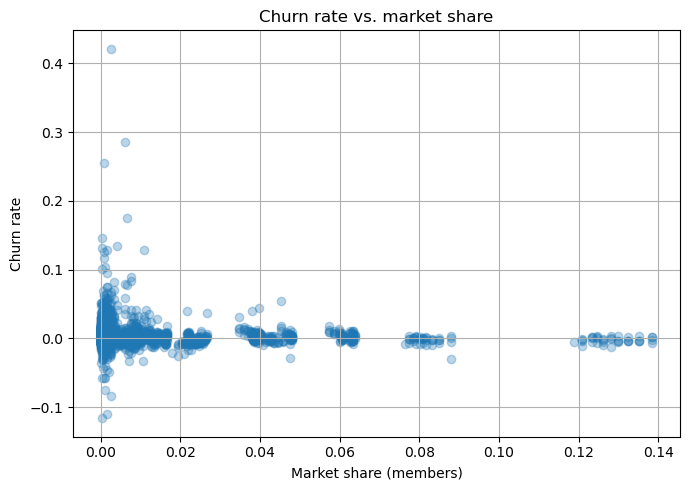

Correlation (churn rate ~ morbidity risk factor): -0.22168197552158123
Correlation (churn rate ~ market share): -0.08907366891812207


In [33]:
import matplotlib.pyplot as plt
import numpy as np

# Scatterplot and correlation: Churn rate vs. morbidity risk factor
rf_mask = pd.to_numeric(merged['Risikofaktor'], errors='coerce').notnull() & merged['churn_rate'].notnull()
rf_vals = pd.to_numeric(merged.loc[rf_mask, 'Risikofaktor'])
churn_vals = merged.loc[rf_mask, 'churn_rate']

plt.figure(figsize=(7,5))
plt.scatter(rf_vals, churn_vals, alpha=0.3)
plt.xlabel('Morbidity risk factor')
plt.ylabel('Churn rate')
plt.title('Churn rate vs. morbidity risk factor')
plt.grid(True)
plt.tight_layout()
plt.show()

corr_rf = np.corrcoef(rf_vals, churn_vals)[0,1]

# Scatterplot and correlation: Churn rate vs. market share (members)
ma_mask = pd.to_numeric(merged['Marktanteil Mitglieder'], errors='coerce').notnull() & merged['churn_rate'].notnull()
ma_vals = pd.to_numeric(merged.loc[ma_mask, 'Marktanteil Mitglieder'])
churn_vals_ma = merged.loc[ma_mask, 'churn_rate']

plt.figure(figsize=(7,5))
plt.scatter(ma_vals, churn_vals_ma, alpha=0.3)
plt.xlabel('Market share (members)')
plt.ylabel('Churn rate')
plt.title('Churn rate vs. market share')
plt.grid(True)
plt.tight_layout()
plt.show()

corr_ma = np.corrcoef(ma_vals, churn_vals_ma)[0,1]

print("Correlation (churn rate ~ morbidity risk factor):", corr_rf)
print("Correlation (churn rate ~ market share):", corr_ma)